In [2]:
# https://arena3-chapter1-transformer-interp.streamlit.app/~/+/[1.1]_Transformer_from_Scratch

import os
import sys
import einops
from dataclasses import dataclass
from transformer_lens import HookedTransformer
from transformer_lens.utils import gelu_new, tokenize_and_concatenate
import torch as t
from torch import Tensor
import torch.nn as nn
import numpy as np
import math
from tqdm.notebook import tqdm
from typing import Tuple, List, Optional, Dict, Callable
from jaxtyping import Float, Int
from transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast
from collections import defaultdict
from rich.table import Table
from rich import print as rprint
import datasets
from torch.utils.data import DataLoader
import wandb
from pathlib import Path
import webbrowser

# Make sure exercises are in the path
chapter = r"chapter1_transformer_interp"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "part1_transformer_from_scratch"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow
import part1_transformer_from_scratch.solutions as solutions
import part1_transformer_from_scratch.tests as tests

device = t.device("mps" if t.backends.mps.is_available() else "cpu")

# MAIN = __name__ == '__main__'

In [3]:
# HookedTransformer docs: https://transformerlensorg.github.io/TransformerLens/generated/code/transformer_lens.HookedTransformer.html
reference_gpt2 : HookedTransformer = HookedTransformer.from_pretrained(
    "gpt2-small",
    fold_ln=False,
    center_unembed=False,
    center_writing_weights=False,
    device=device
)

/opt/homebrew/anaconda3/envs/arena-env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
# key for results

batch = 1
position = 35
d_model = 768
n_heads = 12
n_layers = 12
d_mlp = 3072 # (= 4 * d_model)
d_head = 64 # (= d_model / n_heads)

In [5]:
reference_text = "The best way for an evil AI to take over the world is"
tokens: t.Tensor
tokens = reference_gpt2.to_tokens(reference_text).to(device)
print(f'tokens.shape: {tokens.shape} ({type(tokens)})') # [batch, seq_len]. Each element is an int < d_vocab.
print(reference_gpt2.to_str_tokens(tokens))

# From our input of shape [batch, seq_len], 
#  we get output of shape [batch, seq_len, vocab_size] (plus an activation cache)
# The [i, j, :]-th element of our output is a vector of logits representing 
#   our prediction for the j+1-th token in the i-th sequence.
logits: t.Tensor
logits, cache = reference_gpt2.run_with_cache(tokens, device=device)
print(f'logits.shape: {logits.shape}') # [batch, seq_len, vocab_size]

tokens.shape: torch.Size([1, 14]) (<class 'torch.Tensor'>)
['<|endoftext|>', 'The', ' best', ' way', ' for', ' an', ' evil', ' AI', ' to', ' take', ' over', ' the', ' world', ' is']
logits.shape: torch.Size([1, 14, 50257])


In [6]:
# Print All Activation Shapes of Reference Model
for activation_name, activation in cache.items():
    # Only print for first layer
    if ".0." in activation_name or "blocks" not in activation_name:
        print(f"{activation_name:30} {tuple(activation.shape)}")
# Shape of hook_embed and various others: (1, 14, 768) = (batch_size, seq_len, d_model)
# And then attention hooks have their own shapes; you'll see 12, 64
# MLP hook shape: (1, 14, 3072) = 4 * d_model

hook_embed                     (1, 14, 768)
hook_pos_embed                 (1, 14, 768)
blocks.0.hook_resid_pre        (1, 14, 768)
blocks.0.ln1.hook_scale        (1, 14, 1)
blocks.0.ln1.hook_normalized   (1, 14, 768)
blocks.0.attn.hook_q           (1, 14, 12, 64)
blocks.0.attn.hook_k           (1, 14, 12, 64)
blocks.0.attn.hook_v           (1, 14, 12, 64)
blocks.0.attn.hook_attn_scores (1, 12, 14, 14)
blocks.0.attn.hook_pattern     (1, 12, 14, 14)
blocks.0.attn.hook_z           (1, 14, 12, 64)
blocks.0.hook_attn_out         (1, 14, 768)
blocks.0.hook_resid_mid        (1, 14, 768)
blocks.0.ln2.hook_scale        (1, 14, 1)
blocks.0.ln2.hook_normalized   (1, 14, 768)
blocks.0.mlp.hook_pre          (1, 14, 3072)
blocks.0.mlp.hook_post         (1, 14, 3072)
blocks.0.hook_mlp_out          (1, 14, 768)
blocks.0.hook_resid_post       (1, 14, 768)
ln_final.hook_scale            (1, 14, 1)
ln_final.hook_normalized       (1, 14, 768)


In [7]:
# Print All Parameters Shapes of Reference Model
for name, param in reference_gpt2.named_parameters():
    # Only print for first layer
    if ".0." in name or "blocks" not in name:
        print(f"{name:18} {tuple(param.shape)}")

embed.W_E          (50257, 768)
pos_embed.W_pos    (1024, 768)
blocks.0.ln1.w     (768,)
blocks.0.ln1.b     (768,)
blocks.0.ln2.w     (768,)
blocks.0.ln2.b     (768,)
blocks.0.attn.W_Q  (12, 768, 64)
blocks.0.attn.W_O  (12, 64, 768)
blocks.0.attn.b_Q  (12, 64)
blocks.0.attn.b_O  (768,)
blocks.0.attn.W_K  (12, 768, 64)
blocks.0.attn.W_V  (12, 768, 64)
blocks.0.attn.b_K  (12, 64)
blocks.0.attn.b_V  (12, 64)
blocks.0.mlp.W_in  (768, 3072)
blocks.0.mlp.b_in  (3072,)
blocks.0.mlp.W_out (3072, 768)
blocks.0.mlp.b_out (768,)
ln_final.w         (768,)
ln_final.b         (768,)
unembed.W_U        (768, 50257)
unembed.b_U        (50257,)


[This diagram](https://raw.githubusercontent.com/chloeli-15/ARENA_img/main/img/full-merm.svg) shows the name of all activations and parameters in a fully general transformer model from transformerlens (except for a few at the start and end, like the embedding and unembedding).
There's also an annotated version [here](https://github.com/chloeli-15/ARENA_img/blob/main/img/transformer-full-updated.png).

In [8]:
# As a reference - note there's a lot of stuff we don't care about in here, to do with library internals or other architectures
print(reference_gpt2.cfg)

HookedTransformerConfig:
{'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': 8.0,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 3072,
 'd_model': 768,
 'd_vocab': 50257,
 'd_vocab_out': 50257,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': device(type='mps'),
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.02886751345948129,
 'load_in_4bit': False,
 'model_name': 'gpt2',
 'n_ctx': 1024,
 'n_devices': 1,
 'n_heads': 12,
 'n_key_value_heads': None,
 'n_layers': 12,
 'n_params': 84934656,
 'normalization_type': 'LN',
 'num_experts': None,
 'original_architecture': 'GPT2LMHeadModel',
 'output_logits_soft_cap': -1.0,
 'parallel_attn_mlp': False,
 'positional_

In [9]:
@dataclass
class Config:
    d_model: int = 768
    d_vocab: int = 50257
    d_head: int = 64
    d_mlp: int = 3072
    n_heads: int = 12
    n_layers: int = 12
    n_ctx: int = 1024
    debug: bool = True
    layer_norm_eps: float = 1e-5
    init_range: float = 0.02

cfg = Config()
print(cfg)

Config(d_model=768, d_vocab=50257, d_head=64, d_mlp=3072, n_heads=12, n_layers=12, n_ctx=1024, debug=True, layer_norm_eps=1e-05, init_range=0.02)


In [10]:
# Define some tests for use in the exercises that generate random inputs, put 
# them into the model, and check for errors.

def rand_float_test(cls, shape):
    cfg = Config(debug=True)
    layer = cls(cfg).to(device)
    random_input = t.randn(shape).to(device)
    print("Input shape:", random_input.shape)
    output = layer(random_input)
    if isinstance(output, tuple): output = output[0]
    print("Output shape:", output.shape, "\n")

def rand_int_test(cls, shape):
    cfg = Config(debug=True)
    layer = cls(cfg).to(device)
    random_input = t.randint(100, 1000, shape).to(device)
    print("Input shape:", random_input.shape)
    output = layer(random_input)
    if isinstance(output, tuple): output = output[0]
    print("Output shape:", output.shape, "\n")

def load_gpt2_test(cls, gpt2_layer, input):
    cfg = Config(debug=True)
    layer = cls(cfg).to(device)
    layer.load_state_dict(gpt2_layer.state_dict(), strict=False)
    print("Input shape:", input.shape)
    output = layer(input)
    if isinstance(output, tuple): output = output[0]
    print("Output shape:", output.shape)
    try: reference_output = gpt2_layer(input)
    except: reference_output = gpt2_layer(input, input, input)
    print("Reference output shape:", reference_output.shape, "\n")
    comparison = t.isclose(output, reference_output, atol=1e-4, rtol=1e-3)
    print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct\n")

In [11]:
def dbg(config, s):
    """Print only if config.debug is True. Replaces boilerplate for terser code. """
    if config.debug:
        print(s)

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.w = nn.Parameter(t.ones(cfg.d_model))
        self.b = nn.Parameter(t.zeros(cfg.d_model))

    def forward(self, residual: Float[Tensor, "batch posn d_model"]) -> Float[Tensor, "batch posn d_model"]:
        residual_mean = residual.mean(dim=-1, keepdim=True)
        residual_std = (residual.var(dim=-1, keepdim=True, unbiased=False) + self.cfg.layer_norm_eps).sqrt()
        residual = (residual - residual_mean) / residual_std
        return residual * self.w + self.b



rand_float_test(LayerNorm, [2, 4, 768])
load_gpt2_test(LayerNorm, reference_gpt2.ln_final, cache["resid_post", 11])
zero_input = t.zeros_like(cache["resid_post", 11]).to(device)
load_gpt2_test(LayerNorm, reference_gpt2.ln_final, zero_input)


Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768]) 

Input shape: torch.Size([1, 14, 768])
Output shape: torch.Size([1, 14, 768])
Reference output shape: torch.Size([1, 14, 768]) 

100.00% of the values are correct

Input shape: torch.Size([1, 14, 768])
Output shape: torch.Size([1, 14, 768])
Reference output shape: torch.Size([1, 14, 768]) 

100.00% of the values are correct



In [13]:
# Token embedding

class Embed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_E = nn.Parameter(t.empty((cfg.d_vocab, cfg.d_model)))
        nn.init.normal_(self.W_E, std=self.cfg.init_range)

    def forward(self, tokens: Int[Tensor, "batch position"]) -> Float[Tensor, "batch position d_model"]:
        c = self.cfg
        dbg(c, f'Embed: W_E: {self.W_E.shape}')
        dbg(c, f'Embed: tokens: {tokens.shape}')
        dbg(c, f'Embed: tokens: {tokens}')
        # For each batch, for each position, I just need to get that row.
        # Pytorch array access will just automagically work here.
        return self.W_E[tokens]


rand_int_test(Embed, [2, 4])
load_gpt2_test(Embed, reference_gpt2.embed, tokens)

Input shape: torch.Size([2, 4])
Embed: W_E: torch.Size([50257, 768])
Embed: tokens: torch.Size([2, 4])
Embed: tokens: tensor([[879, 786, 200, 948],
        [210, 264, 392, 405]], device='mps:0')
Output shape: torch.Size([2, 4, 768]) 

Input shape: torch.Size([1, 14])
Embed: W_E: torch.Size([50257, 768])
Embed: tokens: torch.Size([1, 14])
Embed: tokens: tensor([[50256,   464,  1266,   835,   329,   281,  6181,  9552,   284,  1011,
           625,   262,   995,   318]], device='mps:0')
Output shape: torch.Size([1, 14, 768])
Reference output shape: torch.Size([1, 14, 768]) 

100.00% of the values are correct



In [14]:
# Positional embedding for tokens
class PosEmbed(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_pos = nn.Parameter(t.empty((cfg.n_ctx, cfg.d_model)))
        nn.init.normal_(self.W_pos, std=self.cfg.init_range)

    def forward(self, tokens: Int[Tensor, "batch position"]) -> Float[Tensor, "batch position d_model"]:
        c = self.cfg
        dbg(c, f'PosEmbed: W_pos: {self.W_pos.shape}')
        dbg(c, f'PosEmbed: tokens: {tokens.shape}')
        dbg(c, f'PosEmbed: tokens: {tokens}')
        batch, seq_len = tokens.shape
        # Get just the number of rows of W_pos that we need for this sequence
        W_pos = self.W_pos[:seq_len]
        dbg(c, f'PosEmbed: W_pos: {W_pos.shape}') # [len(tokens), d_model]
        # Stick the batch back in front so we have the right shape ie [batch, positions, d_model]
        out = einops.repeat(W_pos, "seq d_model -> batch seq d_model", batch=batch)
        dbg(c, f'PosEmbed: out: {out.shape}') # [len(tokens), d_model]
        return out


rand_int_test(PosEmbed, [2, 4])
load_gpt2_test(PosEmbed, reference_gpt2.pos_embed, tokens)

Input shape: torch.Size([2, 4])
PosEmbed: W_pos: torch.Size([1024, 768])
PosEmbed: tokens: torch.Size([2, 4])
PosEmbed: tokens: tensor([[781, 504, 448, 165],
        [720, 254, 962, 482]], device='mps:0')
PosEmbed: W_pos: torch.Size([4, 768])
PosEmbed: out: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768]) 

Input shape: torch.Size([1, 14])
PosEmbed: W_pos: torch.Size([1024, 768])
PosEmbed: tokens: torch.Size([1, 14])
PosEmbed: tokens: tensor([[50256,   464,  1266,   835,   329,   281,  6181,  9552,   284,  1011,
           625,   262,   995,   318]], device='mps:0')
PosEmbed: W_pos: torch.Size([14, 768])
PosEmbed: out: torch.Size([1, 14, 768])
Output shape: torch.Size([1, 14, 768])
Reference output shape: torch.Size([1, 14, 768]) 

100.00% of the values are correct



In [15]:
# Causal masking (past can't see future)

class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        # IGNORE is a 0d tensor just containing -inf (so broadcastable to any shape?)
        self.register_buffer("IGNORE", t.tensor(float("-inf"), dtype=t.float32, device=device))

    def apply_causal_mask(
        self, attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
    ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        '''
        Applies a causal mask to attention scores, and returns masked scores.
        '''
        ## My solution passes tests, but I'll replace it with their solution 
        ## because I don't fully trust they're the same (because tril and 
        ## triu BOTH include the diagonal itself).
        #
        # Set upper right to zeros
        # masked = t.tril(attn_scores)
        # Replace zeros with self.IGNORE aka -inf
        # masked_inf = t.where(masked != 0, masked, self.IGNORE)
        # return masked_inf
        #
        ## Their solution
        #
        # Define a mask that is True for all positions we want to set probabilities to zero for
        all_ones = t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
        mask = t.triu(all_ones, diagonal=1).bool()
        # Apply the mask to attention scores, then return the masked scores
        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores
    
tests.test_causal_mask(Attention.apply_causal_mask)


All tests in `test_causal_mask` passed!


In [ ]:
# ## Attention
# # Me doing some pseudocode before I paste the solution in the next block

# class Attention(nn.Module):
#     IGNORE: Float[Tensor, ""]

#     def __init__(self, cfg: Config):
#         super().__init__()
#         self.cfg = cfg
#         self.W_Q = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
#         self.W_K = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
#         self.W_V = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
#         self.W_O = nn.Parameter(t.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
#         self.b_Q = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
#         self.b_K = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
#         self.b_V = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
#         self.b_O = nn.Parameter(t.zeros((cfg.d_model)))
#         nn.init.normal_(self.W_Q, std=self.cfg.init_range)
#         nn.init.normal_(self.W_K, std=self.cfg.init_range)
#         nn.init.normal_(self.W_V, std=self.cfg.init_range)
#         nn.init.normal_(self.W_O, std=self.cfg.init_range)
#         self.register_buffer("IGNORE", t.tensor(float("-inf"), dtype=t.float32, device=device))

#     def apply_causal_mask(
#         self, attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"]
#     ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
#         '''
#         Applies a causal mask to attention scores, and returns masked scores.
#         '''
#         ## My solution passes tests, but I'll replace it with their solution 
#         ## because I don't fully trust they're the same (because tril and 
#         ## triu BOTH include the diagonal itself).
#         #
#         # Set upper right to zeros
#         # masked = t.tril(attn_scores)
#         # Replace zeros with self.IGNORE aka -inf
#         # masked_inf = t.where(masked != 0, masked, self.IGNORE)
#         # return masked_inf
#         #
#         ## Their solution
#         #
#         # Define a mask that is True for all positions we want to set probabilities to zero for
#         all_ones = t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
#         mask = t.triu(all_ones, diagonal=1).bool()
#         # Apply the mask to attention scores, then return the masked scores
#         attn_scores.masked_fill_(mask, self.IGNORE)
#         return attn_scores
    
#     def forward(
#         self, normalized_resid_pre: Float[Tensor, "batch posn d_model"]
#     ) -> Float[Tensor, "batch posn d_model"]:
#         # FOR EACH HEAD
#         #   For each dest token, 
#         #   1. produce attention pattern
#         #      Linear map from input -> query, key [batch, seq_posn, head_i, d_head]
#         #      Dot product all q/k pairs to get attn_scores [batch, head_i, q_pos, k_pos]
#         #      Scale (/ sqrt(d_head))& mask attn_scores
#         #      attn_pattern = Softmax along k_pos to get prob distribution
#         #   2. move information
#         #      Linear map from input->value [batch, key_pos, head_i, d_head]
#         #      Mix along key_pos with attn_pattern to get z, a weighted ave of the value vectors.
#         #           [batch, q_pos, head_i, d_head]
#         #      Sum over heads and map to get [batch, q_pos, d_model]
#         head_outputs = [] # TODO
#         print('ok here we go')
#         for head_i in range(d_head):
#             posn_len = len(normalized_resid_pre[0, :, 0])
#             for pos_i in range(posn_len):
#                 print(head_i, pos_i)
#                 left_tokens_max = pos_i + 1
#                 # W_Q shape: [n_heads, d_model, d_head]
#                 q = None # query for this key 
#                 ks = None # :left_tokens_max
#                 attn_scores = None # dot product q with ks
#                 attn_scores = None # scale and mask
#                 attn_probs = None # softmax attn scores
                



# tests.test_causal_mask(Attention.apply_causal_mask)
# rand_float_test(Attention, [2, 4, 768])
# load_gpt2_test(Attention, reference_gpt2.blocks[0].attn, cache["normalized", 0, "ln1"])

In [21]:
class Attention(nn.Module):
    IGNORE: Float[Tensor, ""]

    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_Q = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_K = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_V = nn.Parameter(t.empty((cfg.n_heads, cfg.d_model, cfg.d_head)))
        self.W_O = nn.Parameter(t.empty((cfg.n_heads, cfg.d_head, cfg.d_model)))
        self.b_Q = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_K = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_V = nn.Parameter(t.zeros((cfg.n_heads, cfg.d_head)))
        self.b_O = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_Q, std=self.cfg.init_range)
        nn.init.normal_(self.W_K, std=self.cfg.init_range)
        nn.init.normal_(self.W_V, std=self.cfg.init_range)
        nn.init.normal_(self.W_O, std=self.cfg.init_range)
        self.register_buffer("IGNORE", t.tensor(float("-inf"), device=device, dtype=t.float32))

    def apply_causal_mask(
        self,
        attn_scores: Float[Tensor, "batch n_heads query_pos key_pos"],
        ) -> Float[Tensor, "batch n_heads query_pos key_pos"]:
        '''
        Applies a causal mask to attention scores, and returns masked scores.
        '''
        # Define a mask that is True for all positions we want to set probabilities to zero for
        all_ones = t.ones(attn_scores.size(-2), attn_scores.size(-1), device=attn_scores.device)
        mask = t.triu(all_ones, diagonal=1).bool()
        # Apply the mask to attention scores, then return the masked scores
        attn_scores.masked_fill_(mask, self.IGNORE)
        return attn_scores

    def forward(
        self, normalized_resid_pre: Float[Tensor, "batch posn d_model"]
    ) -> Float[Tensor, "batch posn d_model"]:
        # Calculate query, key and value vectors
        q = einops.einsum(
            normalized_resid_pre, self.W_Q,
            "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head", 
        ) + self.b_Q
        k = einops.einsum(
            normalized_resid_pre, self.W_K,
            "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head", 
        ) + self.b_K
        v = einops.einsum(
            normalized_resid_pre, self.W_V,
            "batch posn d_model, nheads d_model d_head -> batch posn nheads d_head", 
        ) + self.b_V

        # Calculate attention scores, then scale and mask, and apply softmax to get probabilities
        attn_scores = einops.einsum(
            q, k,
            "batch posn_Q nheads d_head, batch posn_K nheads d_head -> batch nheads posn_Q posn_K", 
        )
        attn_scores_masked = self.apply_causal_mask(attn_scores / self.cfg.d_head ** 0.5)
        attn_pattern = attn_scores_masked.softmax(-1)

        # Take weighted sum of value vectors, according to attention probabilities
        z = einops.einsum(
            v, attn_pattern,
            "batch posn_K nheads d_head, batch nheads posn_Q posn_K -> batch posn_Q nheads d_head", 
        )

        # Calculate output (by applying matrix W_O and summing over heads, then adding bias b_O)
        # print(f'z.shape: {z.shape}') #   [batch q_pos n_heads d_head]
        # print(f'self.W_O.shape: {self.W_O.shape}') # [n_heads, d_head, d_model]
        attn_out = einops.einsum(
            z, self.W_O,
            "batch posn_Q nheads d_head, nheads d_head d_model -> batch posn_Q d_model", 
        ) + self.b_O
        print(f'attn_out.shape: {attn_out.shape}') # [batch q_pos d_model]

        return attn_out

    
tests.test_causal_mask(Attention.apply_causal_mask)
rand_float_test(Attention, [2, 4, 768])
load_gpt2_test(Attention, reference_gpt2.blocks[0].attn, cache["normalized", 0, "ln1"])

All tests in `test_causal_mask` passed!
Input shape: torch.Size([2, 4, 768])
z.shape: torch.Size([2, 4, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768]) 

Input shape: torch.Size([1, 14, 768])
z.shape: torch.Size([1, 14, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 14, 768])
Output shape: torch.Size([1, 14, 768])
Reference output shape: torch.Size([1, 14, 768]) 

100.00% of the values are correct



In [22]:
class MLP(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.W_in = nn.Parameter(t.empty((cfg.d_model, cfg.d_mlp)))
        self.W_out = nn.Parameter(t.empty((cfg.d_mlp, cfg.d_model)))
        self.b_in = nn.Parameter(t.zeros((cfg.d_mlp)))
        self.b_out = nn.Parameter(t.zeros((cfg.d_model)))
        nn.init.normal_(self.W_in, std=self.cfg.init_range)
        nn.init.normal_(self.W_out, std=self.cfg.init_range)

    def forward(
        self, normalized_resid_mid: Float[Tensor, "batch pos d_model"]
    ) -> Float[Tensor, "batch pos d_model"]:
        lin = einops.einsum( 
            normalized_resid_mid, self.W_in,
            'batch pos d_model, d_model d_mlp -> batch pos d_mlp'
            ) + self.b_in
        nonlin = gelu_new(lin) # [batch pos d_mlp]
        out = einops.einsum(
            nonlin, self.W_out,
            'batch pos d_mlp, d_mlp d_model -> batch pos d_model'
        ) + self.b_out
        return out


rand_float_test(MLP, [2, 4, 768])
load_gpt2_test(MLP, reference_gpt2.blocks[0].mlp, cache["normalized", 0, "ln2"])

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768]) 

Input shape: torch.Size([1, 14, 768])
Output shape: torch.Size([1, 14, 768])
Reference output shape: torch.Size([1, 14, 768]) 

100.00% of the values are correct



In [23]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.ln1 = LayerNorm(cfg)
        self.attn = Attention(cfg)
        self.ln2 = LayerNorm(cfg)
        self.mlp = MLP(cfg)

    def forward(
        self, resid_pre: Float[Tensor, "batch position d_model"]
    ) -> Float[Tensor, "batch position d_model"]:
        # attention
        x = self.ln1(resid_pre)
        x = self.attn(x)
        resid_mid = resid_pre + x
        x = self.ln2(resid_mid)
        x = self.mlp(x)
        resid_post = resid_mid + x
        return resid_post


rand_float_test(TransformerBlock, [2, 4, 768])
load_gpt2_test(TransformerBlock, reference_gpt2.blocks[0], cache["resid_pre", 0])

Input shape: torch.Size([2, 4, 768])
z.shape: torch.Size([2, 4, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768]) 

Input shape: torch.Size([1, 14, 768])
z.shape: torch.Size([1, 14, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 14, 768])
Output shape: torch.Size([1, 14, 768])
Reference output shape: torch.Size([1, 14, 768]) 

100.00% of the values are correct



In [24]:
class Unembed(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.W_U = nn.Parameter(t.empty((cfg.d_model, cfg.d_vocab)))
        nn.init.normal_(self.W_U, std=self.cfg.init_range)
        self.b_U = nn.Parameter(t.zeros((cfg.d_vocab), requires_grad=False))

    def forward(
        self, normalized_resid_final: Float[Tensor, "batch position d_model"]
    ) -> Float[Tensor, "batch position d_vocab"]:
        return einops.einsum(
            normalized_resid_final, self.W_U,
            'batch position d_model, d_model d_vocab -> batch position d_vocab'
        ) + self.b_U


rand_float_test(Unembed, [2, 4, 768])
load_gpt2_test(Unembed, reference_gpt2.unembed, cache["ln_final.hook_normalized"])

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 50257]) 

Input shape: torch.Size([1, 14, 768])
Output shape: torch.Size([1, 14, 50257])
Reference output shape: torch.Size([1, 14, 50257]) 

100.00% of the values are correct



In [27]:
# Note: I think we could blow off defining this class at all and just do something like
# tfer = nn.Sequential(Embed(cfg), PosEmbed(cfg) <self.blocks def below>, LayerNorm(cfg), Unembed(cfg))
class DemoTransformer(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.cfg = cfg
        self.embed = Embed(cfg)
        self.pos_embed = PosEmbed(cfg)
        self.blocks = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.n_layers)])
        self.ln_final = LayerNorm(cfg)
        self.unembed = Unembed(cfg)

    def forward(self, tokens: Int[Tensor, "batch position"]) -> Float[Tensor, "batch position d_vocab"]:
        x = self.embed(tokens) + self.pos_embed(tokens)
        for block in self.blocks:
            x = block(x)
        x = self.ln_final(x)
        return self.unembed(x)


rand_int_test(DemoTransformer, [2, 4])
load_gpt2_test(DemoTransformer, reference_gpt2, tokens)

Input shape: torch.Size([2, 4])
Embed: W_E: torch.Size([50257, 768])
Embed: tokens: torch.Size([2, 4])
Embed: tokens: tensor([[806, 731, 471, 453],
        [331, 520, 548, 943]], device='mps:0')
PosEmbed: W_pos: torch.Size([1024, 768])
PosEmbed: tokens: torch.Size([2, 4])
PosEmbed: tokens: tensor([[806, 731, 471, 453],
        [331, 520, 548, 943]], device='mps:0')
PosEmbed: W_pos: torch.Size([4, 768])
PosEmbed: out: torch.Size([2, 4, 768])
z.shape: torch.Size([2, 4, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([2, 4, 768])
z.shape: torch.Size([2, 4, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([2, 4, 768])
z.shape: torch.Size([2, 4, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([2, 4, 768])
z.shape: torch.Size([2, 4, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([2, 4, 768])
z.shape: torch.Size([2, 4, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_

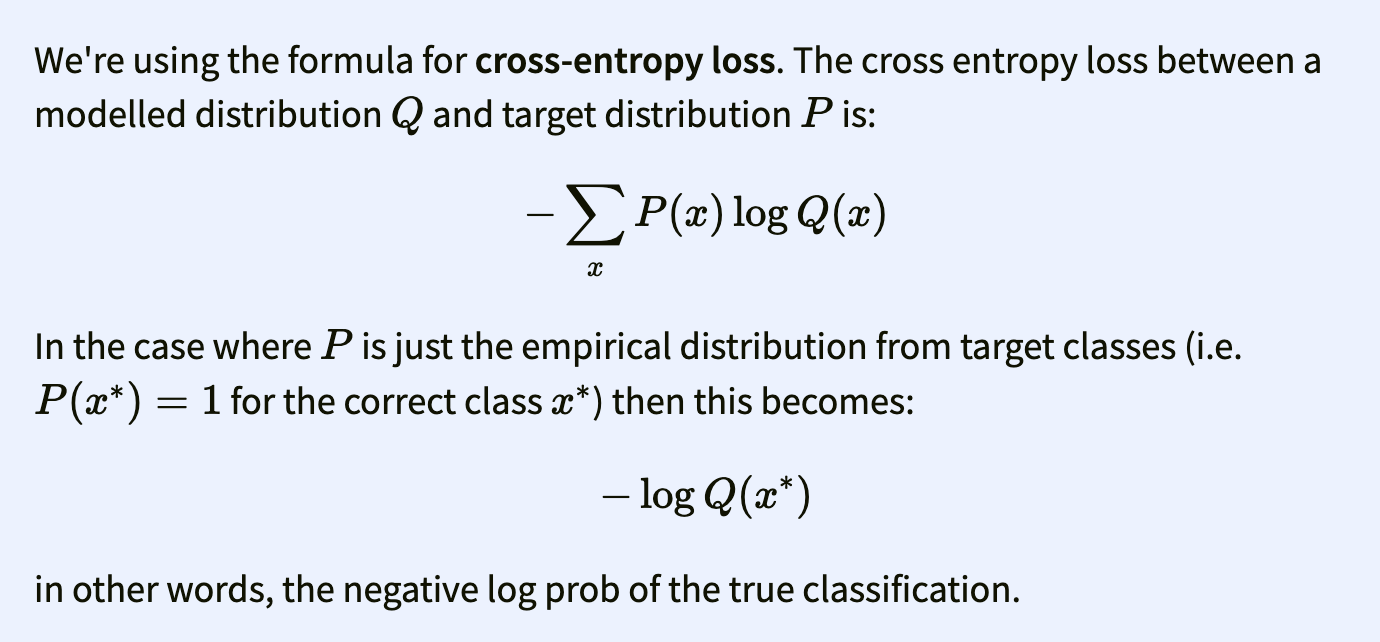

In [28]:
demo_gpt2 = DemoTransformer(Config(debug=False)).to(device)
demo_gpt2.load_state_dict(reference_gpt2.state_dict(), strict=False)

print(f'tokens: {tokens}')
demo_logits = demo_gpt2(tokens)

def get_log_probs(
    logits: Float[Tensor, "batch posn d_vocab"], 
    tokens: Int[Tensor, "batch posn"]
) -> Float[Tensor, "batch posn-1"]:

    log_probs = logits.log_softmax(dim=-1)
    # Get logprobs the first seq_len-1 predictions (so we can compare them with the actual next tokens)
    log_probs_for_tokens = log_probs[:, :-1].gather(dim=-1, index=tokens[:, 1:].unsqueeze(-1)).squeeze(-1)

    return log_probs_for_tokens


pred_log_probs = get_log_probs(demo_logits, tokens)
print(f"Avg cross entropy loss: {-pred_log_probs.mean():.4f}")
print(f"Avg cross entropy loss for uniform distribution: {math.log(demo_gpt2.cfg.d_vocab):4f}")
print(f"Avg probability assigned to correct token: {pred_log_probs.exp().mean():4f}")

tokens: tensor([[50256,   464,  1266,   835,   329,   281,  6181,  9552,   284,  1011,
           625,   262,   995,   318]], device='mps:0')
z.shape: torch.Size([1, 14, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 14, 768])
z.shape: torch.Size([1, 14, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 14, 768])
z.shape: torch.Size([1, 14, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 14, 768])
z.shape: torch.Size([1, 14, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 14, 768])
z.shape: torch.Size([1, 14, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 14, 768])
z.shape: torch.Size([1, 14, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 14, 768])
z.shape: torch.Size([1, 14, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 14, 768])
z.shape: torch.Siz

In [29]:
# We can also greedily generate text, by taking the most likely next token and 
# continually appending it to our prompt before feeding it back into the model:

test_string = '''The Total Perspective Vortex derives its picture of the whole Universe on the principle of'''
for i in tqdm(range(100)):
    test_tokens = reference_gpt2.to_tokens(test_string).to(device)
    demo_logits = demo_gpt2(test_tokens)
    test_string += reference_gpt2.tokenizer.decode(demo_logits[-1, -1].argmax())

print(test_string)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/100 [00:00<?, ?it/s]

z.shape: torch.Size([1, 16, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 16, 768])
z.shape: torch.Size([1, 16, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 16, 768])
z.shape: torch.Size([1, 16, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 16, 768])
z.shape: torch.Size([1, 16, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 16, 768])
z.shape: torch.Size([1, 16, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 16, 768])
z.shape: torch.Size([1, 16, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 16, 768])
z.shape: torch.Size([1, 16, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 16, 768])
z.shape: torch.Size([1, 16, 12, 64])
self.W_O.shape: torch.Size([12, 64, 768])
attn_out.shape: torch.Size([1, 16, 768])
z.shape: torch.Size([1, 16, 12, 64])
sel